# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. Sample new $\tilde{Y}$ by Metropolis Hastings, using randomly perturbed versions of $\tilde{Y}$ as proposals, and using energy to compute the acceptance ratio.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'random'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]\
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ENERGY_POWER = 2                # Power for energy distance kernel. [2]

___

# 2. Load and Plot Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0102


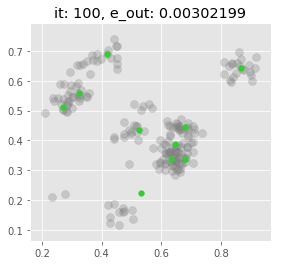

  [*] Overall it/s: 0.0111


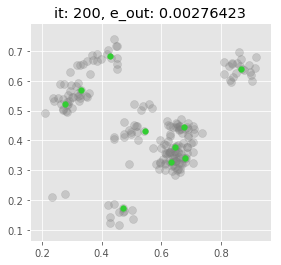

  [*] Overall it/s: 0.0108


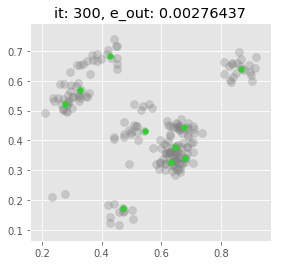

  [*] Time elapsed: 3.47


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=ENERGY_POWER, y_init_option=Y_INIT_OPTION)  # NOTE: Power=2 to derive optimal SP.

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=200, DIM=2, SIG=0.02, C=5

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.69
Loaded M=200, DIM=2, SIG=0.02, C=10

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.41
Loaded M=200, DIM=2, SIG=0.02, C=30

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.35
Loaded M=200, DIM=2, SIG=0.04, C=5

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.45
Loaded M=200, DIM=2, SIG=0.04, C=10

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.49
Loaded M=200, DIM=2, SIG=0.04, C=30

STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.30


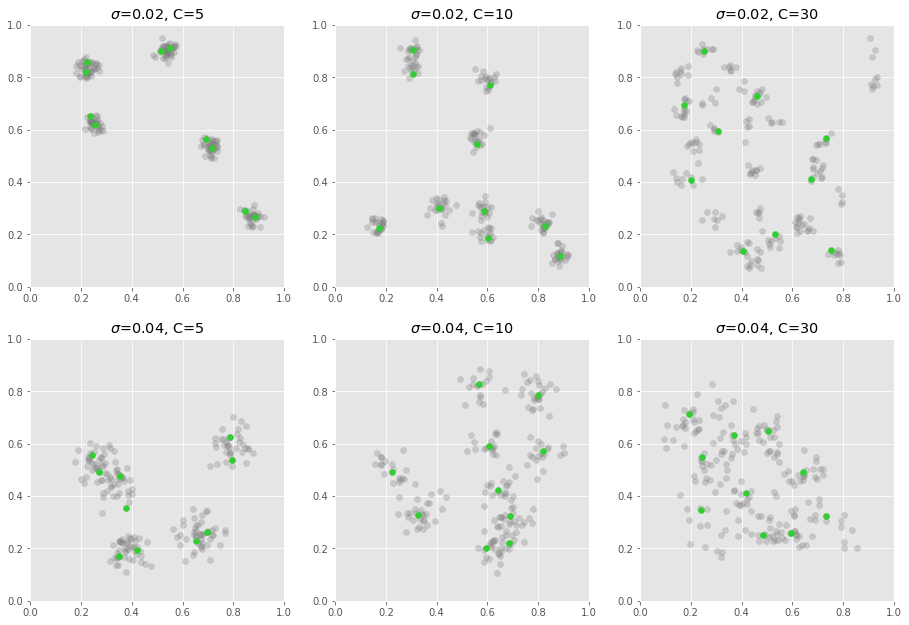

In [5]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(NUM_DATA, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, NUM_SUPP, MAX_ITER,
                                                    LR, is_tf=IS_TF, power=ENERGY_POWER,
                                                    plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=1)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/sp_optimization_various_clusterings.png')

___

## 4. Sample support points.

## 4.0 Sample support points with SP + Exponential Mechanism.

Exp(2 * U / alpha) = Exp(2 * 0.5374 / 5000.00) = Exp(0.00021496)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=105000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00081149


/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:436: RuntimeWarning: divide by zero encountered in power
  term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)


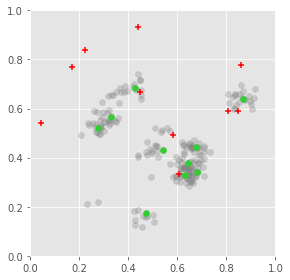

acceptance_rate=0.29425769, step_size=0.02151030
Energy diff: 0.00044498


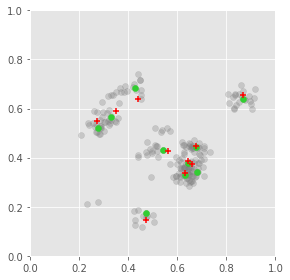

acceptance_rate=0.29827151, step_size=0.10256909
Energy diff: 0.00166100


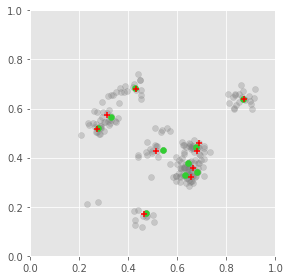

acceptance_rate=0.29945081, step_size=0.16026421
Energy diff: 0.00119854


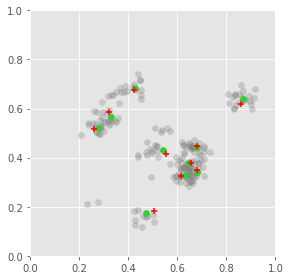

acceptance_rate=0.30220709, step_size=0.06546363
Energy diff: 0.00312626


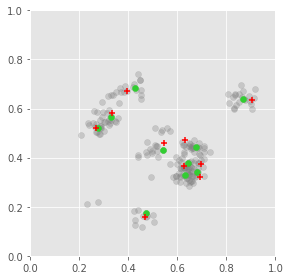

acceptance_rate=0.29921335, step_size=0.01101327
Energy diff: -0.00000829


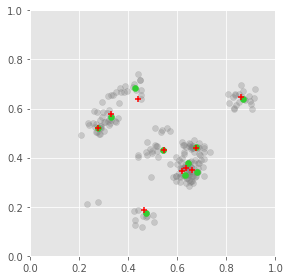

acceptance_rate=0.29928096, step_size=0.01376659
Energy diff: 0.00018420


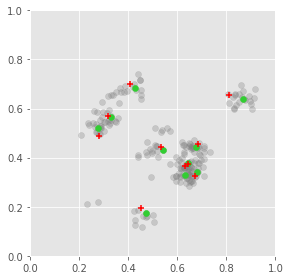

acceptance_rate=0.29943810, step_size=0.01101327
Energy diff: -0.00016121


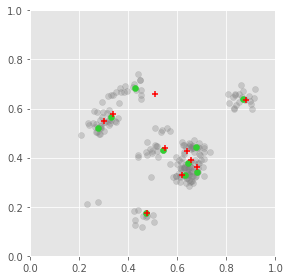

acceptance_rate=0.30166308, step_size=0.06284509
Energy diff: 0.00129370


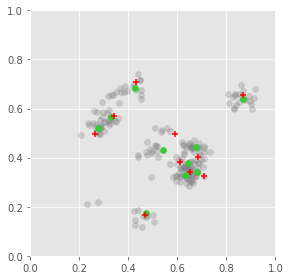

acceptance_rate=0.30033545, step_size=0.01268729
Energy diff: 0.00037860


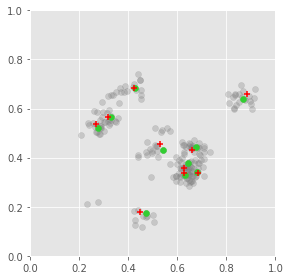

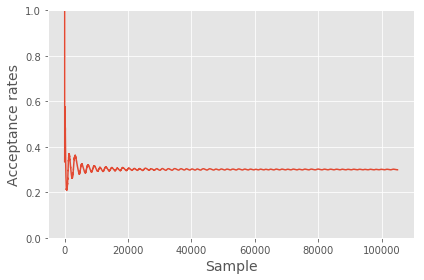

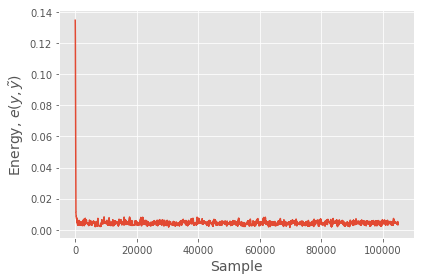

Acceptance rate: 0.299
percent steps that improved energy score: 0.150


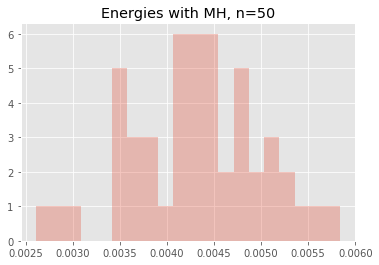

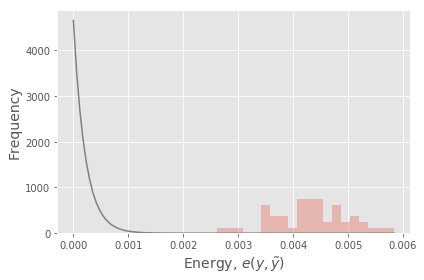

Exponential param: 0.00021496


In [6]:
# Sampling parameters.
NUM_Y_TILDES = 50
ALPHA = 5000  # 10000
save_dir = '../output'
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.8f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt, 'mh', NUM_Y_TILDES,
                         ALPHA, plot=1, save_dir=save_dir, power=ENERGY_POWER,
                         set_seed=True)

# PLOT RESULTS
#plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


# Compare to Exponential density.
p = exponential_param = 2. * energy_sensitivity / ALPHA
xs = np.linspace(0, np.max(energies), 100)
xs_dens = 1 / p * np.exp(-xs / p)
plt.plot(xs, xs_dens, c='gray', label='Exponential density')
plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig('../output/priv_sp_energies.png')
plt.show()
print('Exponential param: {:.8f}'.format(p))

## 4.1 Sample w/ ExpMech on Data Directly (NUM_DATA=NUM_SUPP)

In [7]:
"""
# Sampling parameters.
NUM_Y_TILDES = 21
ALPHA = 10000  # 10000
save_dir = '../output/balog_data_n_eq_m'
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))

(y_tildes,
 energies,
 _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.
                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,
                         save_dir=save_dir,
                         power=ENERGY_POWER)

if PLOT:
    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')


    # Compare to Exponential density.
    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA
    xs = np.linspace(0, np.max(energies), 100)
    xs_dens = 1 / p * np.exp(-xs / p)
    plt.plot(xs, xs_dens, c='gray', label='Exponential density')
    plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'priv_sp_energies.png'))
    plt.show()
    print('p: {}'.format(p))
"""

"\n# Sampling parameters.\nNUM_Y_TILDES = 21\nALPHA = 10000  # 10000\nsave_dir = '../output/balog_data_n_eq_m'\nenergy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=1)  # Note: Num supp = len(x).\nprint(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '\n   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, \n                           2. * energy_sensitivity_num_data / ALPHA))\n\n(y_tildes,\n energies,\n _) = sample_sp_exp_mech(e_opt, energy_sensitivity_num_data, x, x,  # NOTE: Instead of y_opt, use x.\n                         'mh', NUM_Y_TILDES, ALPHA, plot=PLOT,\n                         save_dir=save_dir,\n                         power=ENERGY_POWER)\n\nif PLOT:\n    #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))\n    plt.hist(energies, bins=20, alpha=0.3, density=True, label='Samples')\n\n\n    # Compare to Exponential density.\n    p = exponential_param = 2. * energy_sensitivity_num_data / ALPHA\n    xs = np.linspace(0, np.max(energi

In [8]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

"\n# Compare to energies of e(y_opt, uniform)\nbaseline_energies = np.zeros(NUM_Y_TILDES)\nfor i in range(NUM_Y_TILDES):\n    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))\n    baseline_energies[i] = e_\nplt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))\nplt.hist(baseline_energies, bins=20, alpha=0.3)\nplt.show()\n"

#### Paper: Figure of private support point samples with various alphas.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1.000) = Exp(1.07480231)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 0.93

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00131389
acceptance_rate=0.99572040, step_size=0.20033026
Energy diff: -0.00842041
acceptance_rate=0.99500357, step_size=0.20033026
Energy diff: 0.01048976
acceptance_rate=0.99524036, step_size=0.20033026
Energy diff: 0.00422100
acceptance_rate=0.99500179, step_size=0.20033026
Energy diff: -0.00273712
acceptance_rate=0.99514424, step_size=0.20033026
Energy diff: 0.00691010
acceptance_rate=0.99547727, step_size=0.20033026
Energy diff: -0.00392096
acceptance_rate=0.99591920, step_size=0.20033026
Energy diff: -0.00521745
acceptance_rate=0.99625067, step_size=0.20033026
Energy diff: -0.00109263
acceptance_rate=0.99650849, step_size=0.20033026
Energy diff: 0.02027307

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 100.000) = Exp(0.010748

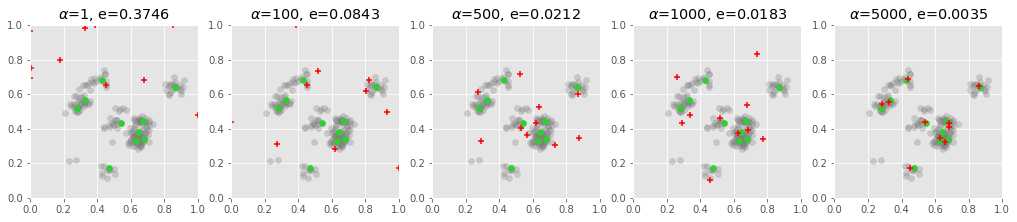

In [9]:
example_alphas = [1, 100, 500, 1000, 5000]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


for i, alpha in enumerate(example_alphas):
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                         x, y_opt, 'mh',
                                         num_y_tildes=1,
                                         alpha=alpha,
                                         plot=False,
                                         power=ENERGY_POWER,
                                         set_seed=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tildes[0, :, 0],
                   y_tildes[0, :, 1],
                   c='red', alpha=1,
                   marker='+')
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/sp_various_alphas.png')
plt.show()

___

## 5. Expand to full data set.

## 5.0 KDE with pre-selected bandwidth.

#### Given privately sampled SP, expand them using KDE and pre-selected bandwidth.

In [10]:
ALPHA = 1000

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)
energy_sensitivity_num_data = get_energy_sensitivity(x, len(x), power=ENERGY_POWER)  # Note: Num supp = len(x).

print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
   '= Exp({:.8f})').format(energy_sensitivity_num_data, ALPHA, 
                           2. * energy_sensitivity_num_data / ALPHA))


FULL_SAMPLE_SIZE = NUM_DATA
PLOT = 1

Exp(2 * U / alpha) = Exp(2 * 0.0282 / 1000.00) = Exp(0.00005643)



Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00172240
acceptance_rate=0.35663338, step_size=0.20033026
Energy diff: 0.00748758
acceptance_rate=0.30620985, step_size=0.20033026
Energy diff: 0.00262782
acceptance_rate=0.29414564, step_size=0.12821137
Energy diff: 0.00152138
acceptance_rate=0.30988933, step_size=0.20033026
Energy diff: 0.00501965
acceptance_rate=0.30391317, step_size=0.20033026
Energy diff: 0.00102843
acceptance_rate=0.30825994, step_size=0.16334383
Energy diff: 0.00027052
acceptance_rate=0.29932667, step_size=0.20033026
Energy diff: -0.00041734
acceptance_rate=0.29905374, step_size=0.10256909
Energy diff: -0.00011299
acceptance_rate=0.30058721, step_size=0.20033026
Energy diff: 0.01023063

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00

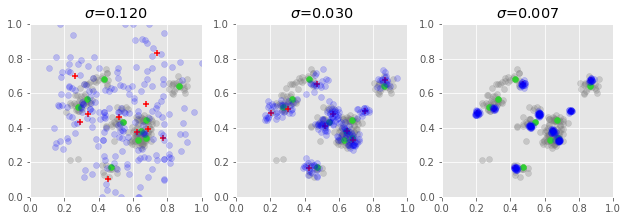

In [11]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt,
                                                          ALPHA, bw,
                                                          FULL_SAMPLE_SIZE, 
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, marker='+')
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/kde_fixed_bandwidth.png')

## 5.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [28]:
ALPHA = 500

In [31]:
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'mh', num_y_tildes=1, alpha=ALPHA,
                               power=ENERGY_POWER, set_seed=False)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=NUM_DATA)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_LOW = 0.0001
BW_HIGH = 0.05
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 500.000) = Exp(0.00214960)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 465.20

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00049557
acceptance_rate=0.47218260, step_size=0.20033026
Energy diff: 0.00322339
acceptance_rate=0.41184868, step_size=0.20033026
Energy diff: 0.00956525
acceptance_rate=0.40361733, step_size=0.20033026
Energy diff: 0.01751441
acceptance_rate=0.39521599, step_size=0.20033026
Energy diff: 0.01139184
acceptance_rate=0.39017424, step_size=0.20033026
Energy diff: 0.00802372
acceptance_rate=0.38681266, step_size=0.20033026
Energy diff: 0.01055439
acceptance_rate=0.38808406, step_size=0.20033026
Energy diff: 0.00643403
acceptance_rate=0.39082307, step_size=0.20033026
Energy diff: 0.00208886
acceptance_rate=0.39358832, step_size=0.20033026
Energy diff: 0.01166173
	 prod_liks=1.457e+20,
	 log_prod_liks=4.643e+01,
	 sum_lliks=4.643e+01


	 prod_liks=8.327e+21

bw: 0.050000, llik: 4.64e+01
bw: 0.047374, llik: 5.05e+01
bw: 0.044747, llik: 5.46e+01
bw: 0.042121, llik: 5.88e+01
bw: 0.039495, llik: 6.32e+01
bw: 0.036868, llik: 6.76e+01
bw: 0.034242, llik: 7.21e+01
bw: 0.031616, llik: 7.68e+01
bw: 0.028989, llik: 8.16e+01
bw: 0.026363, llik: 8.64e+01
bw: 0.023737, llik: 9.14e+01
bw: 0.021111, llik: 9.63e+01
bw: 0.018484, llik: 1.01e+02
bw: 0.015858, llik: 1.05e+02
bw: 0.013232, llik: 1.08e+02
bw: 0.010605, llik: 1.08e+02
bw: 0.007979, llik: 1.01e+02
bw: 0.005353, llik: 6.98e+01
bw: 0.002726, llik: -7.17e+01
bw: 0.000100, llik: -1.22e+04


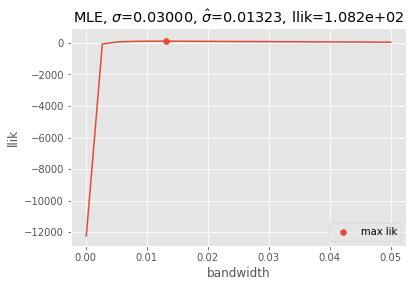

In [32]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/mle_bw_range.png')
plt.show()

#### Show samples with best and worst bandwidth.

	 prod_liks=1.146e+94,
	 log_prod_liks=2.166e+02,
	 sum_lliks=2.166e+02




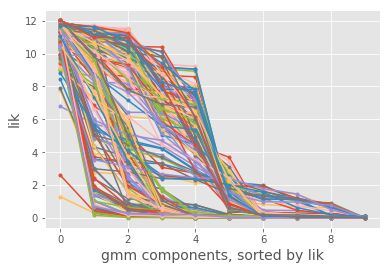

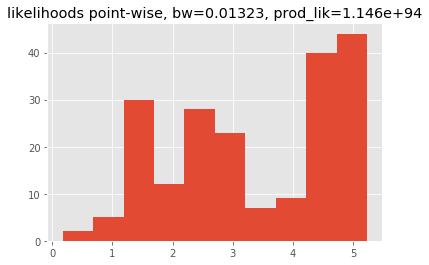

	 prod_liks=1.015e+47,
	 log_prod_liks=1.082e+02,
	 sum_lliks=1.082e+02




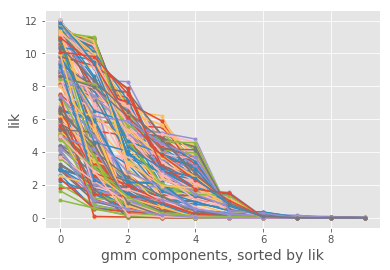

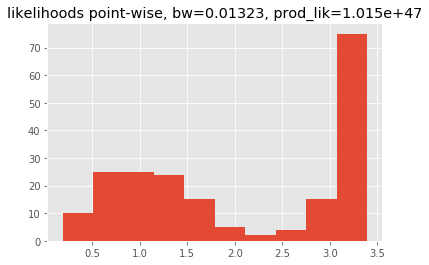

do_log: True
P(x | y_opt, bw_best): 2.17e+02
P(x | y_tilde, bw_best): 1.08e+02


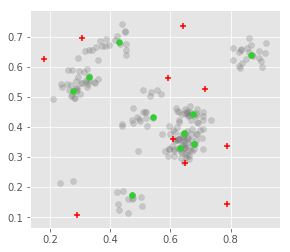

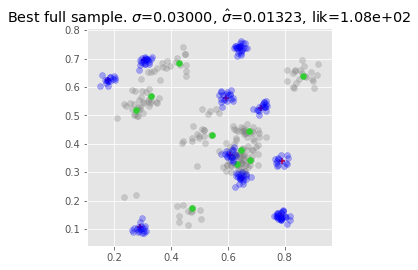

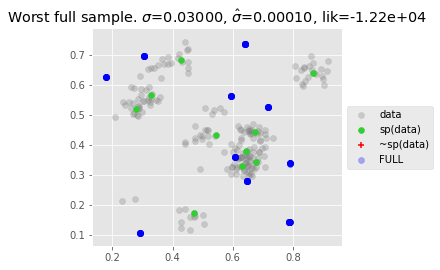

In [33]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ',
                                        plot=True)
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ',
                                          plot=True)
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if 1:
    # Plot with only data and support points.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    #plt.title((r'Best full sample. $\sigma$={:.5f}, '
    #           '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
    #                                                         bw_best,
    #                                                         bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_pre_kde.png')
    plt.show()
    
    # Plot with best bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(
        SIGMA_DATA, bw_best, bw_best_lik))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('../output/mle_best_bw.png')
    plt.show()

    # Plot with worst bandwidth.
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1,
                label='~sp(data)', marker='+')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.


Best bw:       0.013232
raw DP bw:     0.013832
Corrected DP bw: 0.013832

Best bw:       0.013232
raw DP bw:     0.013422
Corrected DP bw: 0.013422

Best bw:       0.013232
raw DP bw:     0.013372
Corrected DP bw: 0.013372

Best bw:       0.013232
raw DP bw:     0.013123
Corrected DP bw: 0.013123


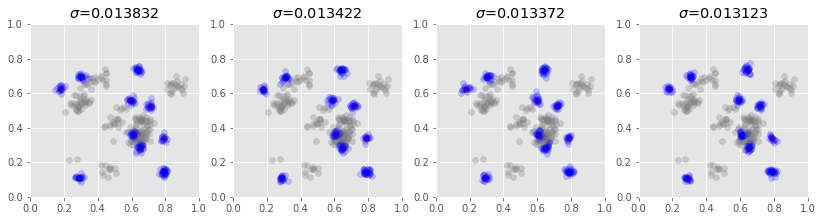

In [34]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))


    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/mle_bw_dp.png')

## 5.3 Repeated draws of private support points.

#### Once with lower budget to show disperse output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00048236
acceptance_rate=0.37945792, step_size=0.20033026
Energy diff: -0.00012573
acceptance_rate=0.30264097, step_size=0.20033026
Energy diff: 0.00020615
acceptance_rate=0.30890052, step_size=0.17723940
Energy diff: 0.00448564
acceptance_rate=0.30239200, step_size=0.20033026
Energy diff: 0.00026236
acceptance_rate=0.30648386, step_size=0.20033026
Energy diff: 0.00719420
acceptance_rate=0.30373721, step_size=0.11815960
Energy diff: 0.00449699
acceptance_rate=0.30014283, step_size=0.20033026
Energy diff: 0.00087214
acceptance_rate=0.29869666, step_size=0.14769950
Energy diff: 0.00147765
acceptance_rate=0.30280908, step_size=0.11815960
Energy diff: 0.00192145

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.0010

acceptance_rate=0.33095578, step_size=0.20033026
Energy diff: -0.00027429
acceptance_rate=0.29550321, step_size=0.16026421
Energy diff: 0.00033003
acceptance_rate=0.29604950, step_size=0.16026421
Energy diff: 0.00192115
acceptance_rate=0.31060336, step_size=0.20033026
Energy diff: 0.00006760
acceptance_rate=0.30305627, step_size=0.11815960
Energy diff: 0.00090317
acceptance_rate=0.30088074, step_size=0.20033026
Energy diff: 0.00883616
acceptance_rate=0.30075495, step_size=0.20033026
Energy diff: 0.00204546
acceptance_rate=0.30423139, step_size=0.20033026
Energy diff: 0.00568175
acceptance_rate=0.29852404, step_size=0.16026421
Energy diff: 0.00515142

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00118052
acceptance_rate=0.37375178, step_size=0.20033026
Energy diff: 0.00223716
acceptance_rate=0.2

acceptance_rate=0.30335475, step_size=0.10256909
Energy diff: 0.00000408
acceptance_rate=0.30176107, step_size=0.15385364
Energy diff: 0.00067789
acceptance_rate=0.30524813, step_size=0.17014982
Energy diff: 0.00405110
acceptance_rate=0.29762925, step_size=0.12821137
Energy diff: 0.00089246
acceptance_rate=0.30278505, step_size=0.20033026
Energy diff: 0.01165721
acceptance_rate=0.30014283, step_size=0.20033026
Energy diff: 0.00123943
acceptance_rate=0.30119621, step_size=0.09846633
Energy diff: 0.00715633
acceptance_rate=0.30106332, step_size=0.18462437
Energy diff: 0.01239410

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 1000.000) = Exp(0.00107480)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 930.40

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00062105
acceptance_rate=0.35805991, step_size=0.20033026
Energy diff: 0.00419346
acceptance_rate=0.29264811, step_size=0.16026421
Energy diff: 0.00194511
acceptance_rate=0.32

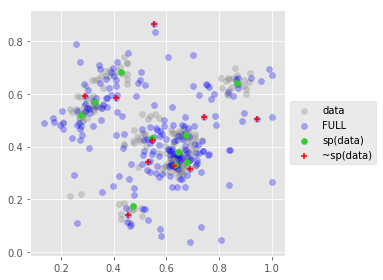

In [17]:
ALPHA = 1000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_dispersed.png')
plt.show()

#### Once with higher budget to show focused output.


Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00039823
acceptance_rate=0.20684736, step_size=0.04201230
Energy diff: 0.00008716
acceptance_rate=0.37901499, step_size=0.03157004
Energy diff: 0.00011859
acceptance_rate=0.28748215, step_size=0.12821137
Energy diff: 0.00113418
acceptance_rate=0.31024634, step_size=0.00845819
Energy diff: -0.00003286
acceptance_rate=0.31905170, step_size=0.10859631
Energy diff: 0.00163022
acceptance_rate=0.28207570, step_size=0.02688787
Energy diff: 0.00060718
acceptance_rate=0.31667007, step_size=0.04546085
Energy diff: 0.00075128
acceptance_rate=0.29030530, step_size=0.06564422
Energy diff: 0.00038041
acceptance_rate=0.31090303, step_size=0.01461576
Energy diff: 0.00066511

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00

acceptance_rate=0.20256776, step_size=0.06564422
Energy diff: 0.00155204
acceptance_rate=0.39971449, step_size=0.01926882
Energy diff: 0.00014176
acceptance_rate=0.29938125, step_size=0.20033026
Energy diff: 0.00202660
acceptance_rate=0.29239557, step_size=0.00881062
Energy diff: -0.00004782
acceptance_rate=0.33533276, step_size=0.07541410
Energy diff: 0.00254101
acceptance_rate=0.28588431, step_size=0.08205528
Energy diff: 0.00074166
acceptance_rate=0.31177311, step_size=0.00811987
Energy diff: 0.00029560
acceptance_rate=0.32172826, step_size=0.10425245
Energy diff: 0.00012214
acceptance_rate=0.29169973, step_size=0.06564422
Energy diff: 0.00088669

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00019700
acceptance_rate=0.20684736, step_size=0.05251538
Energy diff: 0.00101493
acceptance_rate=0.

acceptance_rate=0.31937173, step_size=0.20033026
Energy diff: 0.00711505
acceptance_rate=0.28347019, step_size=0.01720824
Energy diff: 0.00020053
acceptance_rate=0.31905170, step_size=0.06546363
Energy diff: 0.00171184
acceptance_rate=0.28326589, step_size=0.03279499
Energy diff: 0.00089427
acceptance_rate=0.32156703, step_size=0.02464371
Energy diff: -0.00044893
acceptance_rate=0.29833958, step_size=0.16026421
Energy diff: 0.00268352
acceptance_rate=0.29963498, step_size=0.00704849
Energy diff: 0.00023874

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.5374 / 5000.000) = Exp(0.00021496)

Running chain. Length=7000, Burn=5000, Thin=2000
Difference factor: 4652.02

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: -0.00026978
acceptance_rate=0.21968616, step_size=0.05251538
Energy diff: 0.00006845
acceptance_rate=0.37044968, step_size=0.01753891
Energy diff: 0.00011147
acceptance_rate=0.32317944, step_size=0.20033026
Energy diff: 0.00473797
acceptance_rate=0.

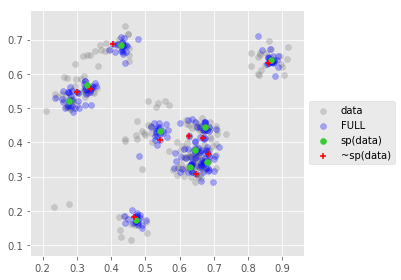

In [18]:
ALPHA = 5000

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(NUM_DATA / NUM_SUPP) + 1
FULL_SAMPLE_SIZE = NUM_DATA

energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_given_bandwidth(e_opt,
                                                          energy_sensitivity,
                                                          x, y_opt, ALPHA,
                                                          BANDWIDTH,
                                                          FULL_SAMPLE_SIZE,
                                                          method='mh',
                                                          power=ENERGY_POWER,
                                                          set_seed=False)
    new_sample.append(y_tilde)

new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('MH, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3, label='FULL')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=1, label='sp(data)')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=1, label='~sp(data)', marker='+')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/repeated_samples_focused.png')
plt.show()

# End.